# Introduction to PyTorch

## Introduction

In this notebook, you will become familiar with PyTorch and relevant tools on a Google Colab instance.

Follow, complete and submit this notebook to canvas to complete lab 1: Introduction to PyTorch.

This notebook is organized into the following steps:

1. Setup an environment ready for machine learning research
2. Validate a preexisting VGG model and report its accuracy
3. Train and validate your own neural network model
4. Explore effects of overfitting on validation accuracy

## Import and Constants Setup

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
from pathlib import Path
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
data_dir = Path('./data')
net_fn = Path('./net')

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


## Reproducibility

In [2]:
torch.manual_seed(0)
np.random.seed(0)

## Pytorch 101: Training a Neural Network

For this section of the lab, we will be using the CIFAR10 dataset. CIFAR10 consists of the following 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

![CIFAR10 Examples](images/cifar10.png)

This lab section consists of some code blocks and text from [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) Pytorch tutorial. This lab has the following steps:

* Loading the CIFAR10 training and test datasets using a torchvision dataloader
* Define a convolutional neural network
* Define a loss function
* Use Pytorch's data loader and pre-processing support
* Train the network on the CIFAR10 training data
* Test the network on the CIFAR10 validation data
* Calculate the top-1 and top-2 accuracy

### Preparing CIFAR10 Data

To prepare the data, we must create a transform, dataset and dataloader.

The transform turns the image into a tensor object as well as performs image transformations such as normalization or cropping. The transformations are all preprocessing techniques that occur before the neural network is validated or trained.

The normalization method takes a mean and a standard deviation for each channel. The first list is the mean for each channel. The second list is the standard deviation for each channel. We normalize the input images to [-1, 1].

Cropping or other shape-based transformations alter the shape of the image to fit into the input space of the neural network. In this case, we are modifying the dataset to fit into the input size.

With CIFAR10, torchvision can directly download the dataset for us; so, we will let torchvision download the dataset by setting `download=True`.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Next is creating the `trainset` and `trainloader`. `trainset` applies our transform of the images as well as derives image and label tuples from the folder hierarchy and/or file naming. `trainloader` provides sampling and further iterator support for the `trainset`. An example of the sampling feature is in the code below where shuffling is enabled. Mini-batches can also be enabled to reduce the sample count. The clean iterator support that `dataloader` provides will be shown later.

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
                                
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


### Defining a Convolutional Neural Network

In this section, we will create a convolutional neural network with one convolutional layer, a pooling layer, and three fully connected layers. The neural network is a `Net` class. Notice how the image dimension of each fully connected layer map to the same domain as the inputs of the next fully connected layer. E.g. `fc1`'s output is the same dimension of `fc2`s input.

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Define a Loss Function and an Optimizer (Question 1)

In this case, we will be using Cross-Entropy loss function. For the optimizer, we will be using SGD with momentum. For this section (and as an exercise in document reading) create a loss function variable called `criterion` and construct the loss function with default values. Further, create a optimizer called `optimizer` constructed with a SGD with the following non-default values: a learning rate of 0.001 and momentum of 0.9.

In [6]:
criterion = nn.CrossEntropyLoss() # TODO create criterion
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # TODO create optimizer

### Train the Network

To train the network, use the following code. There's a few things to note from this code. First, we are using two epochs; that is, the same data is looped through twice. Second, we gather an input and a label for each inner loop iteration. Third, the training calculations themselves are in only four functions: `net()`, `criterion()`, `loss.backward()` and `optimizer.step()`.

As training this network takes a few minutes, once you've trained this network once, we will save it and load it if this cell is ever executed again. This will prevent you from having to wait the entire run when running through the notebook before submission. **If you have changed the criterion or optimizer and need to rerun the code, delete the file found at `./net`.**

In [19]:
num_epochs = 4

if Path(net_fn).is_file():
    net.load_state_dict(torch.load(net_fn)) # load file if previously executed
    print("Skipped Training. Loaded network")
else:
    for epoch in range(num_epochs):
        running_loss = 0.0
        # this allows us to get an index from a foreach loop
        for i, data in enumerate(trainloader, 0):
            # data is a list of [inputs, labels]
            inputs, labels = data

            # Zero parameter gradients
            optimizer.zero_grad()

            # Go forward, backward then optimize
            outputs = net(inputs)   # forward
            loss = criterion(outputs, labels)   # calculate loss
            loss.backward()         # backward
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % (4000 / num_epochs) == (4000 / num_epochs) - 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {(running_loss / (4000 / num_epochs)):.3f}')
                running_loss = 0.0
    
    torch.save(net.state_dict(), net_fn)
    print('Finished Training. Saved network')


Finished Training. Saved network


### Validating the Network on Test Data

#### Question 2

Next, we will validate the network just created on validation or test data. First, create the validation dataset and dataloader below using the training equivalents as inspiration. Assume a batch_size of 4 and 4 workers.

In [20]:
testset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # TODO create test set
testloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=4) # TODO create test loader

Files already downloaded and verified


Then, run the following example code which may help develop an intuition towards network validation and prepare you to validate the network on your own.

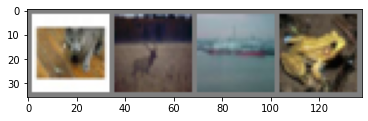

GroundTruth:	 cat   deer  ship  frog 
Predicted:	 cat   deer  ship  frog 


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images and the ground truth
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:\t', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Get the output for such inputs
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:\t', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

You should see four images, the ground truth and the predicted values. Notice that both `labels` and `predicted` are an index into the `class` set. That is, `labels` and `predicted` each point to a class. When they both point to the same class, we have predicted the label and guessed correctly.

Validation is an equivalent process to what we manually did in the above example. Validation is checking if the inputs and labels match. To see this, we must first set the model to evaluation mode. Then, we can iterate through the dataloader and check if the network's prediction matches the label of the data.

#### Question 3

For the rest of this section, write and run Python that outputs the top-1 accuracy and top-2 accuracy of your neural network. Your accuracies should be assigned to `my_top1` and `my_top2`.

In [22]:
# TODO Modify to return top 1 and top 2 accuracy.
# Currently returns top 1 accuracy
def validate_model(model, dataloader,  n = None):
    
    # Set to evaluation mode rather than training mode
    model.eval()

    top1 = 0
    top2 = 0
    total = 0

    # Iterate over data stopping early if n is set
    for i, (inputs, labels) in enumerate(dataloader):
        if (n is not None and i >= n):
            break

        # Run the model and collect the top 2 outputs.
        outputs = model(inputs)
       # _, predicted = outputs.max(outputs, 1)
        _, predicted_1 = torch.topk(outputs,1, largest=True, sorted=True)
        # TODO Change to return top 2 arguments (search topk documentation)
        _, predicted_2 = torch.topk(outputs,2, largest=True, sorted=True)
        labels_new = labels.view(-1,1)
        # Gather statistics
        top1 += torch.sum(predicted_1[:,0] == labels.data)
        # TODO Calculate Top 2 accuracy
        top2 += torch.eq(predicted_2, labels_new).sum().float().item()

        total += torch.sum(predicted_1[:,0] == labels.data)
        total += torch.sum(predicted_1[:,0] != labels.data)
    
    top1_acc = 100 * top1.double() / total
    top2_acc = 100 * top2 / total
    return (top1_acc, top2_acc)

my_top1_acc_chance = 10 # TODO replace with accuracy if you were picking labels by chance
my_top2_acc_chance = 20 # TODO replace with accuracy if you were picking labels by chance
my_top1_acc, my_top2_acc = validate_model(net, testloader)
print(f'Top-1 Accuracy -- Actual: {my_top1_acc:.2f}% By Chance: {my_top1_acc_chance:.2f}%')
print(f'Top-2 Accuracy -- Actual: {my_top2_acc:.2f}% By Chance: {my_top2_acc_chance:.2f}%')

Top-1 Accuracy -- Actual: 73.08% By Chance: 10.00%
Top-2 Accuracy -- Actual: 87.94% By Chance: 20.00%


top1%,top2%<br>1-49.23,70.0<br>2-59.50, 79.03<br>3-67.08,83.78<br>4-73.27, 88.01<br>5-76.04, 89.99

What would be the accuracy if the neural networks were picking labels by chance for both top-1 and top-2 accuracy? How do your results compare to the results by chance?

**TODO Write answer here**<br> The top2 accuracy would be higher than the top1. <br> Given that we have 10 classes (From : classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'), if the nn picks classes randomly by chance, then the chance of it being correct would be 1/10, so accuracy for top1 would be 10%. <br> In case of top2, the first or second class are to be correct, (1/10)+(1/10) = 2/10. Accuracy_top2 = 20%. 

## Overfitting

As discussed in lecture, overfitting describes the cause of the gap between the training and validation errors. We will explore how validation accuracy changes as we intentionally overfit the model.

### Question 4

Train five different models each with a unique number of training epochs from 1-5 and batch size == 4. Then, report their top-1 and top-2 validation accuracy. 

In [23]:
# TODO train five different models with five different epochs
# TODO save the top-1 and top-2 accuracy of each model to the below list with index 0 being a model trained with 1 epoch
val_top1_accuracies = [49.23, 59.50, 67.08, 73.27, 76.04]
val_top2_accuracies = [70.0, 79.03, 83.78, 88.01, 89.99]

After training, you may wish to save the training results in a unique file. See the training example above to see how to do this with `torch.save()`.

### Question 5

Plot the top-1 and top-2 accuracy versus number of training epochs using `matplotlib`. Consider reading the `matplotlib` official documentation [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) or a guide [here](https://www.geeksforgeeks.org/bar-plot-in-matplotlib/).

* Place the number of training epochs in the X-axis. 
* Use a bar graph. 
* Label the axis. 
* Add a title

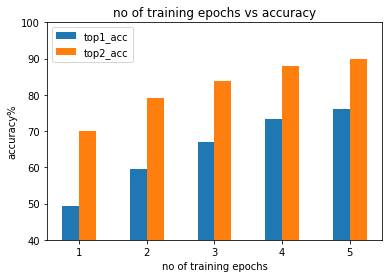

In [24]:
# TODO Plot using matplotlib
x = [1,2,3,4,5]
x_new = [each+0.125 for each in x]
x_new_left = [each-0.125 for each in x]
y1 = val_top1_accuracies
y2 = val_top2_accuracies
plt.bar(x_new_left,y1,0.25,label = 'top1_acc')
plt.bar(x_new,y2,0.25, label = 'top2_acc')
plt.xlabel("no of training epochs")
plt.ylabel("accuracy%")
plt.ylim(40,100)
plt.title("no of training epochs vs accuracy")
plt.legend(loc = 'best')

What happened to the top-1 and top-2 validation accuracy as the number of training epochs increases? How should we improve the validation results?

**TODO Write answer here** <br>
The accuracy increased as the number of epochs increased. And then it does not increase by much. But higher accuracy does not mean a better model. There is a high possibility of overfitting (or in simpler terms, the model remembering data instead of learning the patterns).
<br>  To improve validation, we can introduce aberrations in the input data. We can use data augmentation, introduce noise, etc. Even droppingout neurons will work.

## Conclusion

By completing this lab, you have trained and validated your own machine learning model and explored the effects of overfitting on a network.